In [4]:
import torch
from torch import nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
import sys
import matplotlib.pyplot as plt
import glob

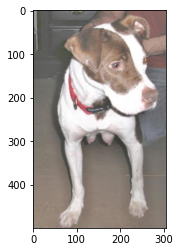

In [5]:
from torchvision.datasets import ImageFolder
from torchvision.transforms import Resize, Normalize, ToTensor, Compose

dataset = ImageFolder("./PetImages", transform=Compose([Resize((224, 224)), ToTensor(), Normalize((0.5, 0.5, 0.5), (1, 1, 1)), ]))
train_set, test_set = torch.utils.data.random_split(dataset, [int(0.8 * len(dataset)), len(dataset) - int(0.8 * len(dataset))])

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=256, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=True)

file = np.random.choice(glob.glob("./PetImages/*/*.jpg"))
plt.imshow(plt.imread(file))

In [6]:
from torchvision.models import resnet18

model = resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

model.fc = nn.Linear(512, 2)

In [7]:
def train_epoch(model, data_loader, optimizer, criterion, return_losses=False, device='cuda:0'):
    model = model.to(device).train()
    total_loss = 0
    num_batches = 0
    all_losses = []
    total_predictions = np.array([])#.reshape((0, ))
    total_labels = np.array([])#.reshape((0, ))
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            # Move Batch to GPU
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            # Update weights
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            # Update descirption for tqdm
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
            all_losses.append(loss.detach().item())
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    if return_losses:
        return metrics, all_losses
    else:
        return metrics


def validate(model, data_loader, criterion, device='cuda:0'):
    model = model.eval()
    total_loss = 0
    num_batches = 0
    total_predictions = np.array([])
    total_labels = np.array([])
    with tqdm(total=len(data_loader), file=sys.stdout) as prbar:
        for images, labels in data_loader:
            images = images.to(device)
            labels = labels.to(device)
            predicted = model(images)
            loss = criterion(predicted, labels)
            accuracy = (predicted.argmax(1) == labels).float().mean()
            prbar.set_description(
                f"Loss: {round(loss.item(), 4)} "
                f"Accuracy: {round(accuracy.item() * 100, 4)}"
            )
            prbar.update(1)
            total_loss += loss.item()
            total_predictions = np.append(total_predictions, predicted.argmax(1).cpu().detach().numpy())
            total_labels = np.append(total_labels, labels.cpu().detach().numpy())
            num_batches += 1
    metrics = {'loss': total_loss / num_batches}
    metrics.update({"accuracy": (total_predictions == total_labels).mean()})
    return metrics

def fit(model, epochs, train_data_loader, validation_data_loader, optimizer, criterion):
    all_train_losses = []
    epoch_train_losses = []
    epoch_eval_losses = []
    for epoch in range(epochs):
        # Train step
        print(f"Train Epoch: {epoch}")
        train_metrics, one_epoch_train_losses = train_epoch(
            model=model,
            data_loader=train_data_loader,
            optimizer=optimizer,
            return_losses=True,
            criterion=criterion
        )
        # Save Train losses
        all_train_losses.extend(one_epoch_train_losses)
        epoch_train_losses.append(train_metrics['loss'])
        # Eval step
        print(f"Validation Epoch: {epoch}")
        with torch.no_grad():
            validation_metrics = validate(
                model=model,
                data_loader=validation_data_loader,
                criterion=criterion
            )
        # Save eval losses
        epoch_eval_losses.append(validation_metrics['loss'])

In [8]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.fc.parameters(), 1e-4)
fit(model, 10, train_dataloader, test_dataloader, optimizer, criterion)

Train Epoch: 0


RuntimeError: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx

In [ ]:
cl = 1
while cl == 1:
    i = np.random.randint(0, len(train_set))
    cl = train_set[i][1]
    image = train_set[i][0]
    image = image.to('cuda:0')
    # Разрешим вычисление градиента по картинке
    image.requires_grad = True

    pred = model(image[None])
    predicted_label = pred.argmax(1).item()
    confidence = pred.softmax(1)[0][predicted_label]

# красиво рисуем
if predicted_label == 1:
    plt.title("Dog, confidence = %0.4f" % confidence.item())
else:
    plt.title("Cat, confidence =  %0.4f" % confidence.item())
plt.imshow(image.cpu().detach().numpy().transpose((1, 2, 0)) + 0.5)